In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

O conjunto de dados **38-Cloud** está organizado da seguinte maneira:

#### **Pastas Principais:**

- **cloud_training**: Contém os dados de treinamento.
- **cloud_test**: Contém os dados de teste.
- **metadata_training**: Contém os metadados correspondentes aos dados de treinamento.
- **metadata_test**: Contém os metadados correspondentes aos dados de teste.

#### **Subpastas em `cloud_training` e `cloud_test`:**

Dentro das pastas `cloud_training` e `cloud_test`, tem as seguintes subpastas:

- **train_red** / **test_red**: Contém as imagens da banda vermelha (Red).
- **train_green** / **test_green**: Contém as imagens da banda verde (Green).
- **train_blue** / **test_blue**: Contém as imagens da banda azul (Blue).
- **train_nir** / **test_nir**: Contém as imagens da banda do infravermelho próximo (Near Infrared - NIR).
- **train_gt** / **test_gt**: Contém as máscaras de nuvens (Ground Truth - GT).
- **natural_False_color**: Imagens em cores falsas naturais (pode ser útil para visualização).
- **entire_scene_gts**: Máscaras de nuvens para cenas inteiras.

#### **Pastas de Metadados:**

- **metadata_training** e **metadata_test**: Contêm arquivos de metadados (`.txt`) correspondentes às cenas das imagens.

Definir os Diretórios das Bandas e Máscaras

In [4]:
# Diretórios das bandas de treinamento
train_red_dir = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud'
train_green_dir = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud'
train_blue_dir = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud'
train_gt_dir = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud'

# Diretórios das bandas de teste
test_red_dir = '../data/raw/38-Cloud_test/test_red'
test_green_dir = '../data/raw/38-Cloud_test/test_green'
test_blue_dir = '../data/raw/38-Cloud_test/test_blue'

Listar os Arquivos Disponíveis

In [5]:
# Listar arquivos de treinamento
red_files = sorted(os.listdir(train_red_dir))
green_files = sorted(os.listdir(train_green_dir))
blue_files = sorted(os.listdir(train_blue_dir))
mask_files = sorted(os.listdir(train_gt_dir))

print(f'Número de arquivos de banda vermelha: {len(red_files)}')
print(f'Número de arquivos de banda verde: {len(green_files)}')
print(f'Número de arquivos de banda azul: {len(blue_files)}')
print(f'Número de máscaras: {len(mask_files)}')

Número de arquivos de banda vermelha: 26301
Número de arquivos de banda verde: 26301
Número de arquivos de banda azul: 26301
Número de máscaras: 26301


In [6]:
def remove_band_prefix(filename):
    base_name = os.path.splitext(filename)[0]
    prefixes = ['red_', 'green_', 'blue_', 'gt_']
    for prefix in prefixes:
        if base_name.startswith(prefix):
            base_name = base_name[len(prefix):]
            break
    return base_name

Verificar Correspondência entre as Bandas e as Máscaras

In [7]:
# Verificar se os nomes dos arquivos correspondem entre as bandas e as máscaras
for r_file, g_file, b_file, m_file in zip(red_files, green_files, blue_files, mask_files):
    base_name_r = remove_band_prefix(r_file)
    base_name_g = remove_band_prefix(g_file)
    base_name_b = remove_band_prefix(b_file)
    base_name_m = remove_band_prefix(m_file)
    
    if not (base_name_r == base_name_g == base_name_b == base_name_m):
        print(f'Arquivos não correspondentes: {r_file}, {g_file}, {b_file}, {m_file}')

Visualizando os dados

In [8]:
def combine_bands(red_path, green_path, blue_path):
    # Carregar as imagens das bandas
    red = Image.open(red_path)
    green = Image.open(green_path)
    blue = Image.open(blue_path)
    
    # Converter as imagens para arrays numpy
    red_array = np.array(red).astype(np.float32)
    green_array = np.array(green).astype(np.float32)
    blue_array = np.array(blue).astype(np.float32)
    
    # Normalizar cada banda individualmente
    red_array = (red_array - red_array.min()) / (red_array.max() - red_array.min()) * 255.0
    green_array = (green_array - green_array.min()) / (green_array.max() - green_array.min()) * 255.0
    blue_array = (blue_array - blue_array.min()) / (blue_array.max() - blue_array.min()) * 255.0
    
    # Converter arrays para uint8
    red_image = Image.fromarray(red_array.astype(np.uint8))
    green_image = Image.fromarray(green_array.astype(np.uint8))
    blue_image = Image.fromarray(blue_array.astype(np.uint8))
    
    # Mesclar as bandas em uma imagem RGB
    rgb_image = Image.merge('RGB', (red_image, green_image, blue_image))
    return rgb_image

def visualize_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Imagem RGB')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara de Nuvens')
    plt.axis('off')
    
    plt.show()

A função Image.merge('RGB', bands) espera que as bandas sejam imagens em modo 'L' (8 bits, escala de cinza) ou 'F' (32 bits float), compatíveis para serem combinadas em uma imagem RGB. O modo I;16 não é compatível diretamente para mesclagem em uma imagem RGB.

Para resolver o problema, precisamos converter as imagens das bandas para o modo 'L' (8 bits) antes de combiná-las. No entanto, simplesmente converter pode levar à perda de dados se não ajustarmos os valores dos pixels corretamente.

Vamos selecionar um arquivo para visualizar

In [9]:
# Selecionar um índice aleatório
import random
idx = random.randint(0, len(red_files) - 1)

# Obter os caminhos das bandas e da máscara
red_path = os.path.join(train_red_dir, red_files[idx])
green_path = os.path.join(train_green_dir, green_files[idx])
blue_path = os.path.join(train_blue_dir, blue_files[idx])
mask_path = os.path.join(train_gt_dir, mask_files[idx])

# Combinar as bandas
image = combine_bands(red_path, green_path, blue_path)

# Carregar a máscara
mask = Image.open(mask_path).convert('L')
mask_array = np.array(mask)
# Converter a máscara para valores binários (0 e 1)
mask_array = (mask_array > 0).astype(np.uint8) * 255
mask = Image.fromarray(mask_array)

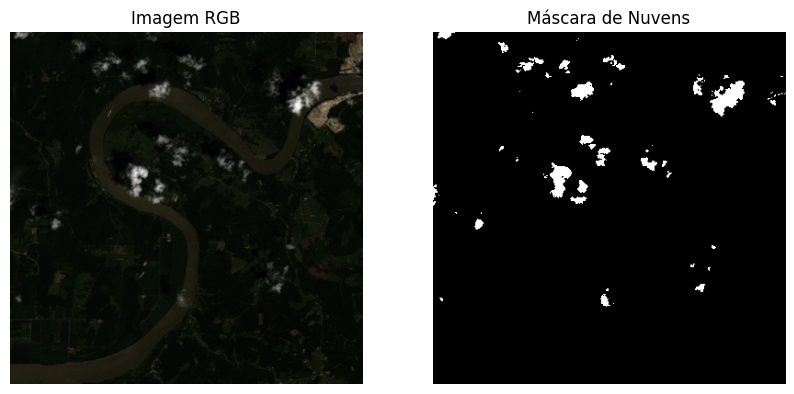

In [10]:
visualize_image_and_mask(image, mask)

Verificar as Dimensões das Imagens e Máscaras

In [11]:
dimensions = []
for r_file, g_file, b_file, m_file in zip(red_files, green_files, blue_files, mask_files):
    red = Image.open(os.path.join(train_red_dir, r_file))
    green = Image.open(os.path.join(train_green_dir, g_file))
    blue = Image.open(os.path.join(train_blue_dir, b_file))
    mask = Image.open(os.path.join(train_gt_dir, m_file))
    
    if not (red.size == green.size == blue.size == mask.size):
        print(f'Dimensões não correspondentes em {r_file}')
    else:
        dimensions.append(red.size)

# Contar as diferentes dimensões
dimension_counts = Counter(dimensions)
print('Dimensões das imagens e máscaras:', dimension_counts)

Dimensões das imagens e máscaras: Counter({(384, 384): 26301})


Verificar se Existem Imagens Corrompidas

In [12]:
def is_image_corrupted(image_path):
    try:
        Image.open(image_path).verify()
        return False
    except Exception as e:
        print(f'Imagem corrompida: {image_path}, erro: {e}')
        return True

# Verificar bandas
corrupted_files = []
for dir_path, file_list in zip(
    [train_red_dir, train_green_dir, train_blue_dir, train_gt_dir],
    [red_files, green_files, blue_files, mask_files]
):
    for file_name in file_list:
        if is_image_corrupted(os.path.join(dir_path, file_name)):
            corrupted_files.append(file_name)

print(f'Arquivos corrompidos: {corrupted_files}')

Arquivos corrompidos: []


Analisar os Valores Únicos nas Máscaras

In [13]:
unique_values = set()
for m_file in mask_files:
    mask_path = os.path.join(train_gt_dir, m_file)
    mask = Image.open(mask_path).convert('L')
    mask_array = np.array(mask)
    unique_values.update(np.unique(mask_array))

print(f'Valores únicos nas máscaras: {unique_values}')

Valores únicos nas máscaras: {np.uint8(0), np.uint8(255)}


As máscaras são imagens binárias, onde cada pixel representa uma das duas classes possíveis. Nuvem ou não nuvem.